In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import kagglehub
import random
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow.keras.backend as tfback

In [3]:
# Set random seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 30
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
print("Downloading dataset...")
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print(f"Downloaded to: {path}")

Downloaded to: /kaggle/input/brain-tumor-mri-dataset


In [6]:
# Function to load and preprocess images
def load_data(base_path):
    images = []
    labels = []
    
    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(base_path, 'Training', class_name)
        print(f"Loading {class_name} images from {class_path}")
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

In [7]:
# Load the data
X, y = load_data(path)
print(f"Loaded {len(X)} images with shape {X.shape}")

Loading glioma images from /kaggle/input/brain-tumor-mri-dataset/Training/glioma
Loading meningioma images from /kaggle/input/brain-tumor-mri-dataset/Training/meningioma
Loading notumor images from /kaggle/input/brain-tumor-mri-dataset/Training/notumor
Loading pituitary images from /kaggle/input/brain-tumor-mri-dataset/Training/pituitary
Loaded 5712 images with shape (5712, 224, 224, 3)


In [8]:
# Convert labels to one-hot encoding
y_onehot = to_categorical(y, num_classes=NUM_CLASSES)

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train.argmax(axis=1))

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (3655, 224, 224, 3), Validation set: (914, 224, 224, 3), Test set: (1143, 224, 224, 3)


In [10]:
# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [11]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

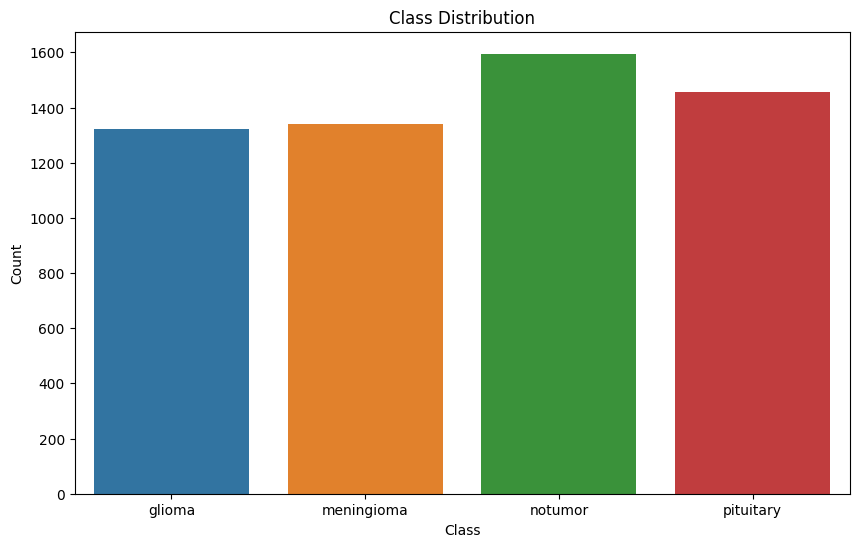

In [12]:
# Visualize class distribution
def plot_class_distribution(y):
    if y.ndim > 1:  # If one-hot encoded
        y_classes = np.argmax(y, axis=1)
    else:
        y_classes = y
        
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_classes)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(y)

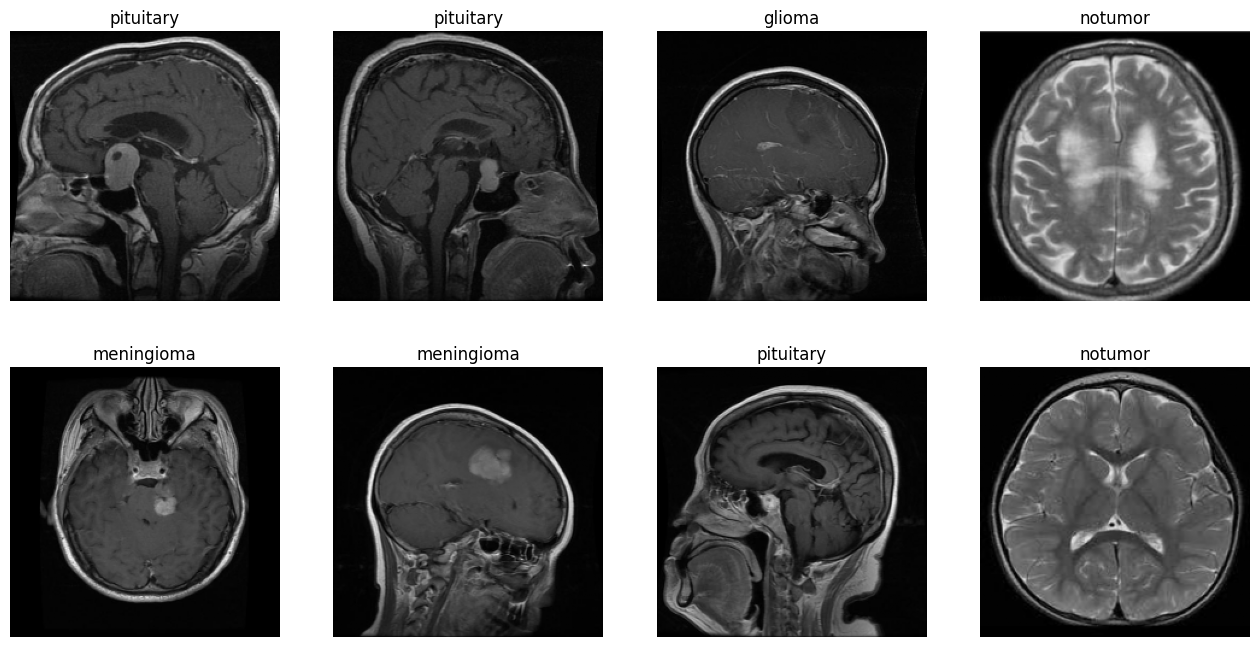

In [13]:
 # Visualize sample images
def plot_sample_images(X, y, n=8):
    plt.figure(figsize=(16, 8))
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        idx = np.random.randint(0, X.shape[0])
        plt.imshow(X[idx])
        plt.title(CLASS_NAMES[np.argmax(y[idx])])
        plt.axis('off')
    plt.show()

plot_sample_images(X_train, y_train)

In [14]:
# Model building - Base CNN
def create_base_model(input_shape, name):
    if name == 'vgg16':
        base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif name == 'resnet50':
        base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif name == 'efficientnetb0':
        base_model = applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError(f"Model {name} not supported")
    
    # Freeze the base model
    base_model.trainable = False
    
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=f'{name}_model')
    return model

In [15]:
# Create models
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model_vgg = create_base_model(input_shape, 'vgg16')
model_resnet = create_base_model(input_shape, 'resnet50')
model_efficientnet = create_base_model(input_shape, 'efficientnetb0')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Compile models
def compile_model(model):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_vgg = compile_model(model_vgg)
model_resnet = compile_model(model_resnet)
model_efficientnet = compile_model(model_efficientnet)

In [17]:
# Callbacks
def get_callbacks(model_name):
    checkpoint = ModelCheckpoint(
    f'best_{model_name}.keras',  # <-- change .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        verbose=1,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    return [checkpoint, early_stopping, reduce_lr]

In [18]:
# Train models
def train_model(model, model_name):
    print(f"\nTraining {model_name}...")
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        callbacks=get_callbacks(model_name),
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return model, history


Training vgg16...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5510 - loss: 1.0644
Epoch 1: val_accuracy improved from -inf to 0.80306, saving model to best_vgg16.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 73s 476ms/step - accuracy: 0.5519 - loss: 1.0626 - val_accuracy: 0.8031 - val_loss: 0.5874 - learning_rate: 0.0010
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7853 - loss: 0.5736
Epoch 2: val_accuracy did not improve from 0.80306
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 318ms/step - accuracy: 0.7853 - loss: 0.5735 - val_accuracy: 0.7702 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8045 - loss: 0.5133
Epoch 3: val_accuracy improved from 0.80306 to 0.83917, saving model to best_vgg16.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 326ms/step - accuracy: 0.8046 - loss: 0.5130 - val_accuracy: 0.8392 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8424 - loss: 0.4551
E

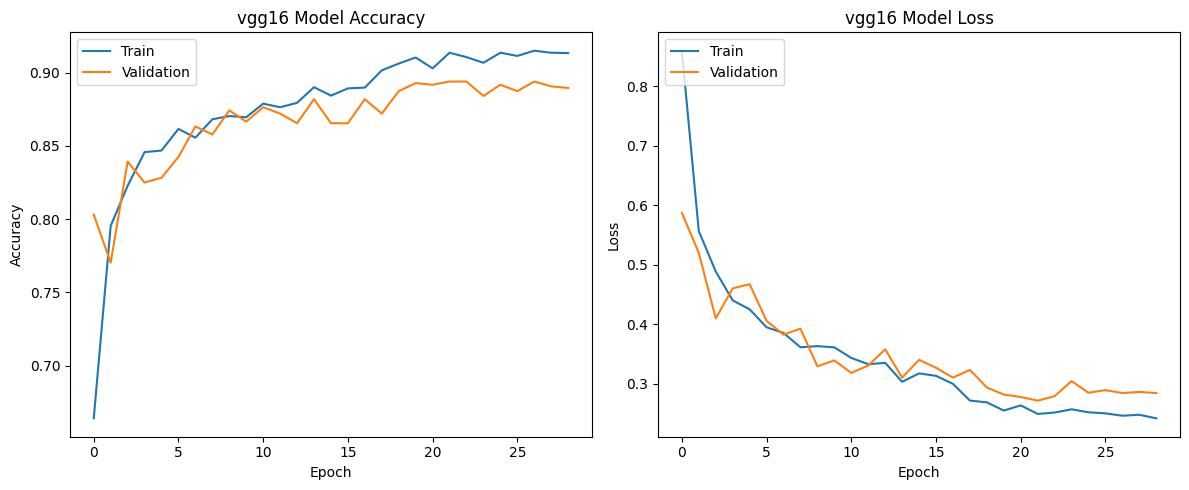

In [19]:
model_vgg, history_vgg = train_model(model_vgg, 'vgg16')


Training resnet50...
Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3555 - loss: 1.4523
Epoch 1: val_accuracy improved from -inf to 0.53501, saving model to best_resnet50.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 411ms/step - accuracy: 0.3560 - loss: 1.4509 - val_accuracy: 0.5350 - val_loss: 1.0322 - learning_rate: 0.0010
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.4928 - loss: 1.1251
Epoch 2: val_accuracy improved from 0.53501 to 0.55033, saving model to best_resnet50.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 311ms/step - accuracy: 0.4927 - loss: 1.1252 - val_accuracy: 0.5503 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5133 - loss: 1.0895
Epoch 3: val_accuracy improved from 0.55033 to 0.69694, saving model to best_resnet50.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.5134 - loss: 1.0893 - val_accuracy: 0.6969 - val_loss: 0.9198 - learning_rate: 0.0010
Epoch 4/3

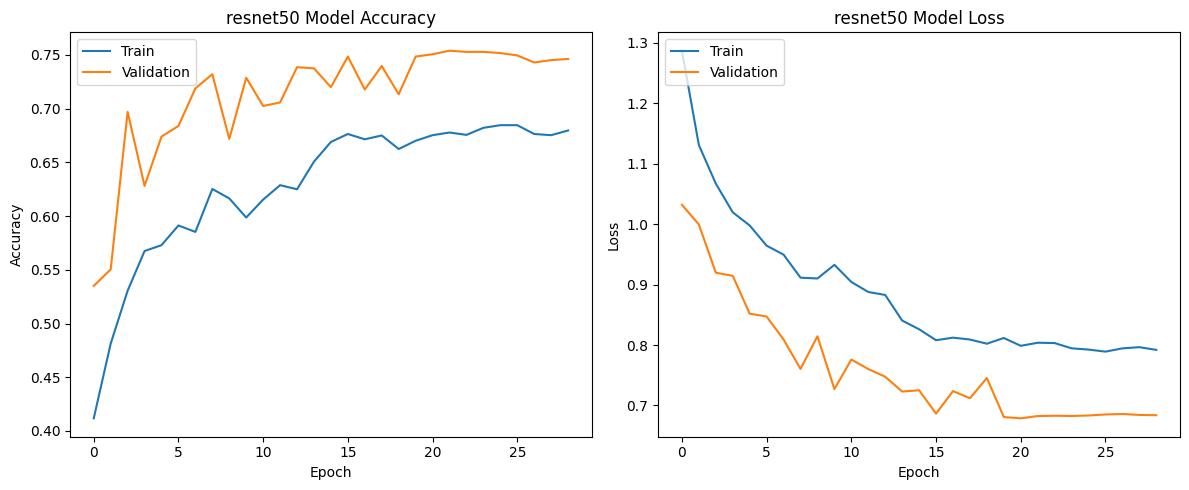

In [20]:
model_resnet, history_resnet = train_model(model_resnet, 'resnet50')


Training efficientnetb0...
Epoch 1/30
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.2489 - loss: 1.3950
Epoch 1: val_accuracy improved from -inf to 0.25492, saving model to best_efficientnetb0.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 80s 496ms/step - accuracy: 0.2492 - loss: 1.3950 - val_accuracy: 0.2549 - val_loss: 1.3878 - learning_rate: 0.0010
Epoch 2/30
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2663 - loss: 1.3879
Epoch 2: val_accuracy improved from 0.25492 to 0.27899, saving model to best_efficientnetb0.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 287ms/step - accuracy: 0.2663 - loss: 1.3879 - val_accuracy: 0.2790 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 3/30
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2817 - loss: 1.3848
Epoch 3: val_accuracy did not improve from 0.27899
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 279ms/step - accuracy: 0.2815 - loss: 1.3849 - val_accuracy: 0.2790 - val_loss: 1.3841 - learning_rate: 0.0010
Epoch 4/30
114/115 ━━━━━━━━━━━━━

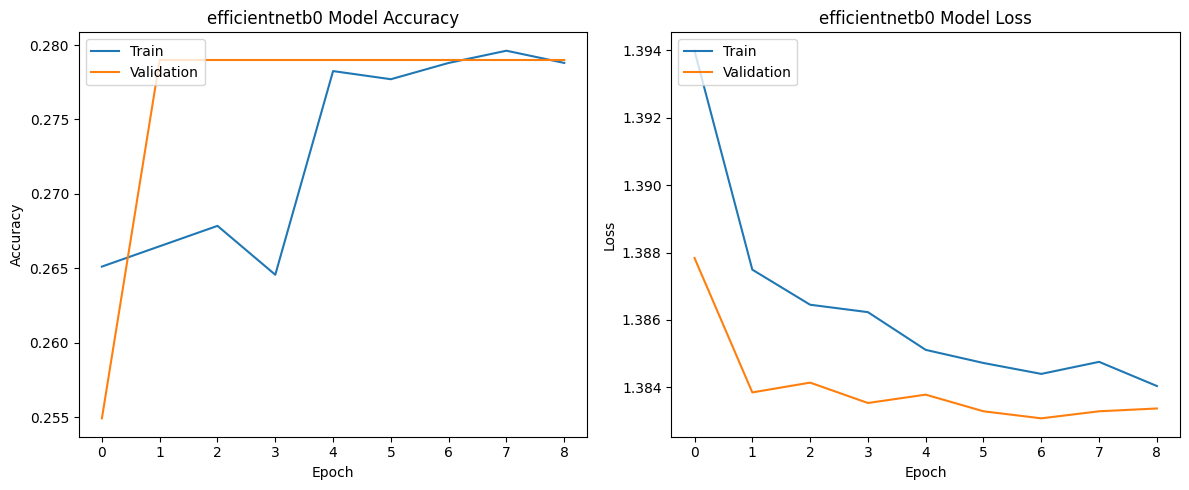

In [21]:
model_efficientnet, history_efficientnet = train_model(model_efficientnet, 'efficientnetb0')

In [22]:
# Evaluate models
def evaluate_model(model, model_name):
    print(f"\nEvaluating {model_name}...")
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} Test accuracy: {score[1]:.4f}")
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))
    
    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return y_pred



Evaluating VGG16...
VGG16 Test accuracy: 0.8950
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step

VGG16 Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.82      0.87       264
  meningioma       0.81      0.77      0.79       268
     notumor       0.95      0.98      0.97       319
   pituitary       0.88      0.98      0.93       292

    accuracy                           0.90      1143
   macro avg       0.89      0.89      0.89      1143
weighted avg       0.89      0.90      0.89      1143



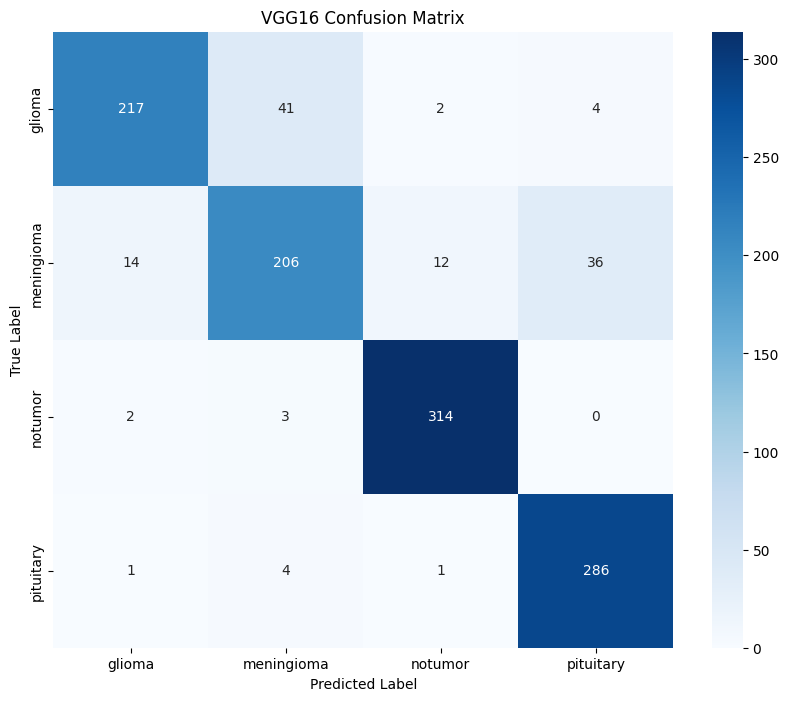

In [23]:
y_pred_vgg = evaluate_model(model_vgg, 'VGG16')


Evaluating ResNet50...
ResNet50 Test accuracy: 0.7297
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step

ResNet50 Classification Report:
              precision    recall  f1-score   support

      glioma       0.74      0.54      0.62       264
  meningioma       0.62      0.50      0.55       268
     notumor       0.88      0.89      0.89       319
   pituitary       0.67      0.93      0.78       292

    accuracy                           0.73      1143
   macro avg       0.73      0.72      0.71      1143
weighted avg       0.73      0.73      0.72      1143



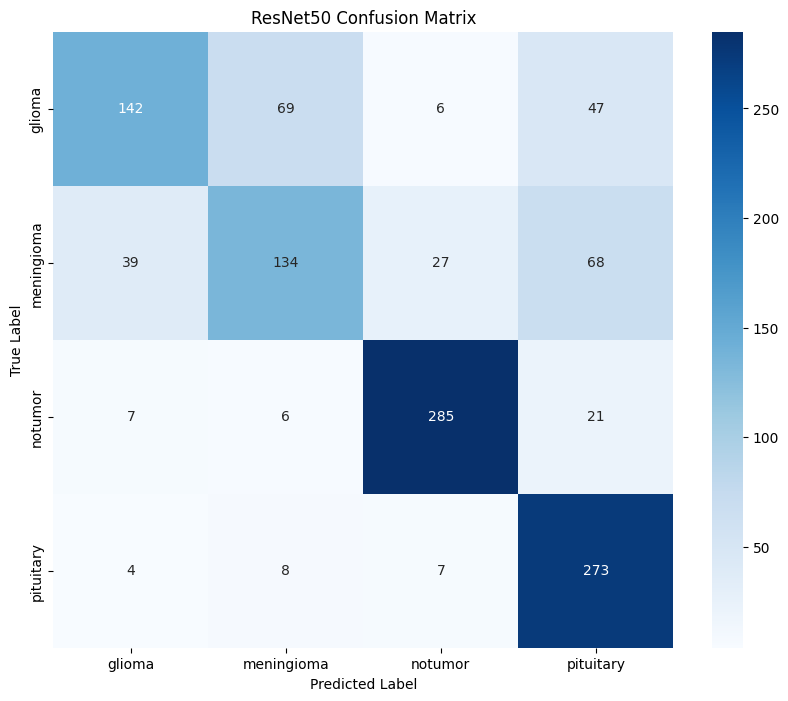

In [24]:
y_pred_resnet = evaluate_model(model_resnet, 'ResNet50')


Evaluating EfficientNetB0...
EfficientNetB0 Test accuracy: 0.2791
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step

EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       264
  meningioma       0.00      0.00      0.00       268
     notumor       0.28      1.00      0.44       319
   pituitary       0.00      0.00      0.00       292

    accuracy                           0.28      1143
   macro avg       0.07      0.25      0.11      1143
weighted avg       0.08      0.28      0.12      1143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


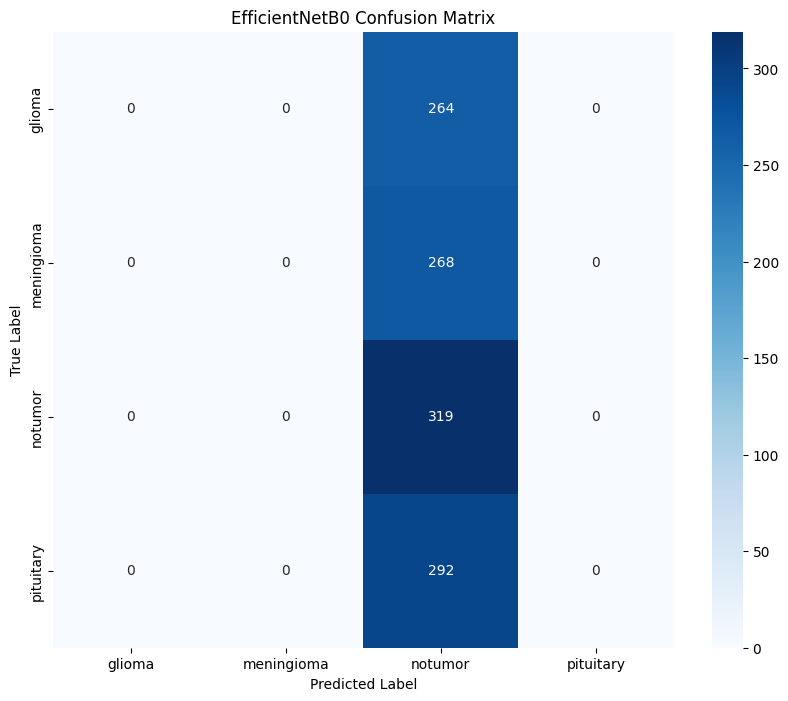

In [25]:
y_pred_efficientnet = evaluate_model(model_efficientnet, 'EfficientNetB0')

In [26]:
# Create ensemble predictions
y_pred_ensemble = (y_pred_vgg + y_pred_resnet + y_pred_efficientnet) / 3
y_pred_ensemble_classes = np.argmax(y_pred_ensemble, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [27]:
# Evaluate ensemble
print("\nEnsemble Model Classification Report:")
print(classification_report(y_true_classes, y_pred_ensemble_classes, target_names=CLASS_NAMES))


Ensemble Model Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.81      0.88       264
  meningioma       0.81      0.74      0.77       268
     notumor       0.93      0.99      0.96       319
   pituitary       0.85      0.98      0.91       292

    accuracy                           0.89      1143
   macro avg       0.89      0.88      0.88      1143
weighted avg       0.89      0.89      0.88      1143



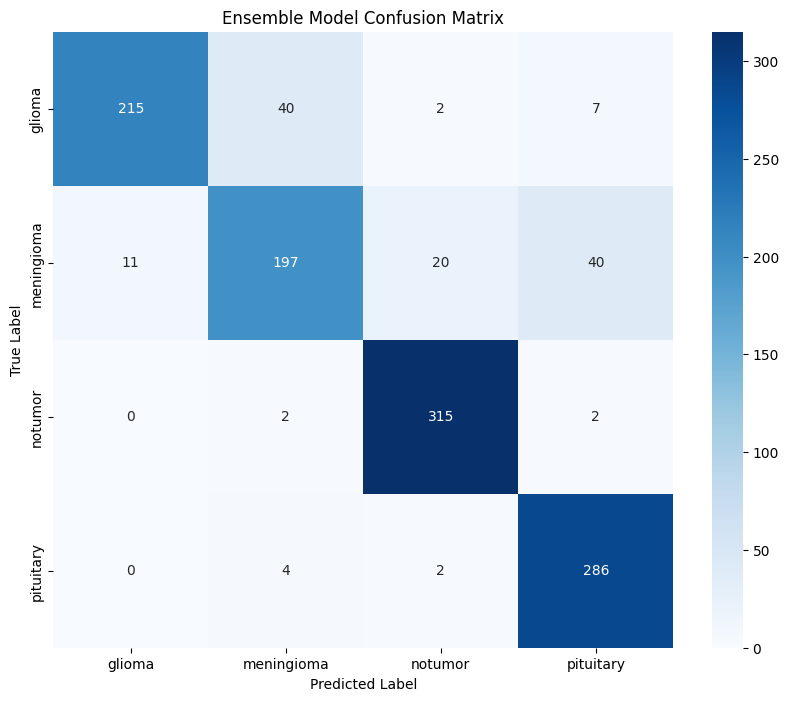

In [28]:
# Confusion matrix for ensemble
cm = confusion_matrix(y_true_classes, y_pred_ensemble_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [53]:
# Print available layers to help identify the correct layer names
def print_model_layers(model, model_name):
    print(f"\n{model_name} layers:")
    for i, layer in enumerate(model.layers):
        print(f"{i}: {layer.name}")

In [54]:
print_model_layers(model_vgg, "VGG16")
print_model_layers(model_resnet, "ResNet50")
print_model_layers(model_efficientnet, "EfficientNetB0")


VGG16 layers:
0: input_layer_1
1: vgg16
2: global_average_pooling2d
3: dense
4: dropout
5: predictions

ResNet50 layers:
0: input_layer_3
1: resnet50
2: global_average_pooling2d_1
3: dense_1
4: dropout_1
5: predictions

EfficientNetB0 layers:
0: input_layer_5
1: efficientnetb0
2: global_average_pooling2d_2
3: dense_2
4: dropout_2
5: predictions


In [ ]:

def grad_cam(model, img_array, class_idx):
    """
    Generate Grad-CAM heatmap for a specific class prediction.
    Works for VGG16, ResNet50, EfficientNetB0 variants.
    """
    # 1) Find the base-model and its last conv layer:
    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model) and any(name in layer.name
                                                          for name in ['vgg16','resnet50','efficientnet']):
            base_model = layer
            break
    if base_model is None:
        print("Could not find base model")
        return None

    # pick a sensible last-conv if the named one isn't present:
    if 'vgg16' in base_model.name:
        layer_name = 'block5_conv3'
    elif 'resnet50' in base_model.name:
        layer_name = 'conv5_block3_out'
    else:
        layer_name = 'top_activation'

    try:
        last_conv = base_model.get_layer(layer_name)
    except ValueError:
        # fallback: find the last Conv2D in the base
        for l in reversed(base_model.layers):
            if isinstance(l, tf.keras.layers.Conv2D):
                last_conv = l
                break

    print(f"Using layer: {last_conv.name}")

    # 2) Build a model that returns [last_conv_output, final_logits]
    cam_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv.output, model.output]
    )

    # 3) Run the forward+backward pass:
    img_tensor = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        # get both conv feature‑maps and predictions
        conv_outputs, predictions = cam_model(img_tensor)
        tape.watch(conv_outputs)

        # if user passed class_idx = -1, pick top prediction
        if class_idx == -1:
            class_idx = tf.argmax(predictions[0])

        # the score for our target class
        class_channel = predictions[:, class_idx]

    # 4) gradients of that score w.r.t. the conv outputs
    grads = tape.gradient(class_channel, conv_outputs)

    # 5) global average pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # 6) weight the feature-maps by these pooled grads
    conv_outputs = conv_outputs[0]   # remove batch dim
    heatmap = tf.zeros(conv_outputs.shape[0:2], dtype=tf.float32)
    for i, w in enumerate(pooled_grads):
        heatmap += w * conv_outputs[:,:,i]

    # 7) ReLU + normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()


In [86]:
def visualize_grad_cam(model, img_array, img_orig, class_idx, model_name):
    """
    Generate and display Grad-CAM heatmap
    """
    # Generate heatmap
    heatmap = grad_cam(model, img_array, class_idx)
    
    if heatmap is None:
        print(f"Could not generate heatmap for {model_name}")
        return
    
    # Convert to uint8 and resize
    heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose heatmap on original image
    if len(img_orig.shape) == 2:  # If grayscale
        img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img_orig
        
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_rgb)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    
    ax[2].imshow(superimposed_img)
    ax[2].set_title('Grad-CAM Overlay')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [87]:
def visualize_samples_with_gradcam(models, X_test, y_test, CLASS_NAMES, num_samples=3):
    """
    Visualize test samples with Grad-CAM for each model
    """
    model_vgg, model_resnet, model_efficientnet = models
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for idx in indices:
        img_orig = X_test[idx].copy()
        # Convert normalized image back to 0-255 range for display
        if img_orig.max() <= 1.0:
            img_orig = (img_orig * 255).astype('uint8')
        
        img_array = np.expand_dims(X_test[idx], axis=0)
        true_class = np.argmax(y_test[idx])
        
        print(f"\nTrue Class: {CLASS_NAMES[true_class]}")
        
        # Make predictions with each model
        vgg_pred = np.argmax(model_vgg.predict(img_array, verbose=0)[0])
        resnet_pred = np.argmax(model_resnet.predict(img_array, verbose=0)[0])
        efficientnet_pred = np.argmax(model_efficientnet.predict(img_array, verbose=0)[0])
        
        # Ensemble prediction
        avg_preds = (model_vgg.predict(img_array, verbose=0) + 
                    model_resnet.predict(img_array, verbose=0) + 
                    model_efficientnet.predict(img_array, verbose=0)) / 3
        ensemble_pred = np.argmax(avg_preds[0])
        
        # Print predictions
        print(f"VGG16 Prediction: {CLASS_NAMES[vgg_pred]}")
        print(f"ResNet50 Prediction: {CLASS_NAMES[resnet_pred]}")
        print(f"EfficientNetB0 Prediction: {CLASS_NAMES[efficientnet_pred]}")
        print(f"Ensemble Prediction: {CLASS_NAMES[ensemble_pred]}")
        
        # Visualize Grad-CAM for each model
        print("\nVGG16 Grad-CAM:")
        visualize_grad_cam(model_vgg, img_array, img_orig, true_class, "VGG16")
        
        print("\nResNet50 Grad-CAM:")
        visualize_grad_cam(model_resnet, img_array, img_orig, true_class, "ResNet50")
        
        print("\nEfficientNetB0 Grad-CAM:")
        visualize_grad_cam(model_efficientnet, img_array, img_orig, true_class, "EfficientNetB0")


In [88]:
def inspect_model(model):
    """Print detailed information about model architecture"""
    print(f"Model: {model.name}")
    print(f"Input shape: {model.input_shape}")
    print(f"Output shape: {model.output_shape}")
    print("\nLayers:")
    
    for i, layer in enumerate(model.layers):
        # try the usual attrs, then fall back
        in_shape  = getattr(layer, 'input_shape',  None) or getattr(layer, 'batch_input_shape', None)
        out_shape = getattr(layer, 'output_shape', None) or getattr(layer, 'batch_output_shape', None)
        
        print(f"{i}: {layer.name} ({type(layer).__name__}) - Input: {in_shape}, Output: {out_shape}")
        
        # if it's a nested model/Sequential, you can recurse or just note it
        if hasattr(layer, 'layers'):
            print(f"  ↳ Submodel `{layer.name}` with {len(layer.layers)} layers")


In [1]:
# Example usage:
inspect_model(model_vgg)
inspect_model(model_resnet)
inspect_model(model_efficientnet)

models = (model_vgg, model_resnet, model_efficientnet)
visualize_samples_with_gradcam(models, X_test, y_test, CLASS_NAMES, num_samples=3)

NameError: name 'inspect_model' is not defined